# Assignment 8
### Phyllis Kho

## 1. Reproduce the SST curve from the figure below
Use the sst.mnmean.nc file that we worked with in class, located at http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc.

You don’t have to match the stylistic details, or use different colors above and below zero, just the “3mth running mean” curve.

Load the data as an Xarray dataset. Drop the time_bnds variable as we did in class and trim the data to 1950 onward for this assignment.

Now calculate the climatology and the SST anomaly.

Now reproduce the plot. Keep the rolling 3-month average of the SST anomaly as a DataArray for the next question.



In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt

In [2]:
ds = xr.open_dataset('/data9/GR6901/data/sst.mnmean.nc', drop_variables=['time_bnds'])

ERROR 1: PROJ: proj_create_from_database: Open of /opt/sw/anaconda3/2023.09/envs/pangeo23/share/proj failed


In [3]:
ds

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 2042)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2024-02-01
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2024-03-03

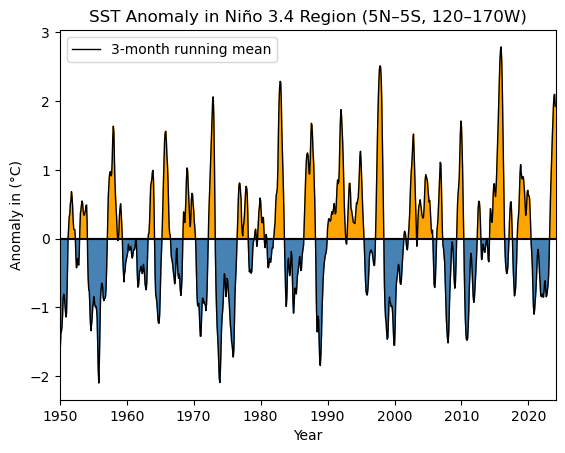

In [38]:
# Extract the SST data for the Niño 3.4 region from 1950 onwards
nino34_sst = ds.sst.sel(lat=slice(5, -5), lon=slice(190, 240), time=slice('1950-01-01','2024-02-01'))

# Define a function to calculate monthly anomalies
def anomaly(x):
    return (x - x.mean())

# Calculate anomalies for each month
nino34_sst_anomalies = nino34_sst.groupby('time.month').apply(anomaly)

# Calculate the 3-month running mean of anomalies
running_nino34_sst_anomalies = nino34_sst_anomalies.rolling(time=3, center=True).mean()

# Calculate average 3-month running mean of anomalies over entire Niño 3.4 region aka ONI
ONI = running_nino34_sst_anomalies.mean(dim=('lat', 'lon'))

# Plot ONI
plt.plot(ONI.time, ONI, color='black', label='3-month running mean', linewidth=1)
plt.fill_between(ONI.time, 0, ONI, 
                 where=ONI > 0, color='orange')
plt.fill_between(ONI.time, 0, ONI, 
                 where=ONI < 0, color='steelblue')

plt.axhline(y=0, color='black', linestyle='-');

plt.xlim(ONI.time.min(), ONI.time.max());
plt.title('SST Anomaly in Niño 3.4 Region (5N–5S, 120–170W)');
plt.xlabel('Year');
plt.ylabel('Anomaly in (°C)');
plt.legend();

## 2. Calculate boolean timeseries representing the positive / negative ENSO phases
Refer to the definitions of warm/cold phases above.

Plot them somehow.

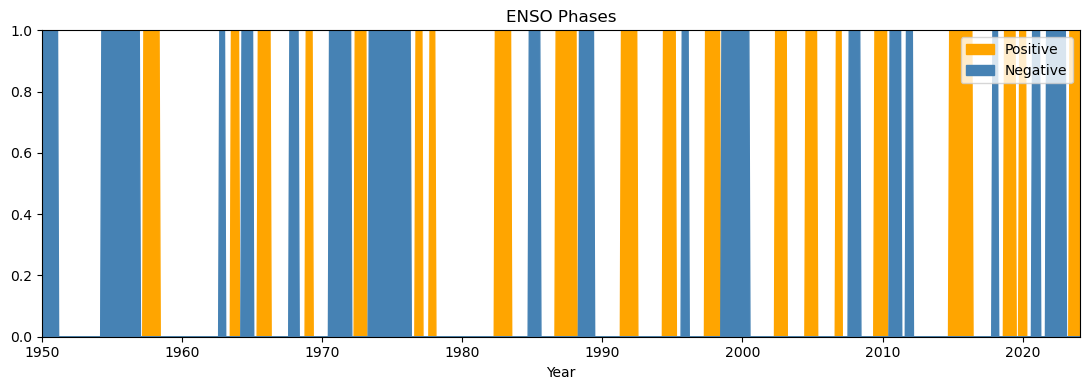

In [69]:
# Create boolean masks for warm and cold phases
elnino_mask = ((ONI > 0.5).rolling(time=5, center=True).sum()==5).rolling(time=5, center=True, min_periods=1).max()
lanina_mask = ((ONI < -0.5).rolling(time=5, center=True).sum()==5).rolling(time=5, center=True, min_periods=1).max()

# Plot the boolean time series for warm and cold phases
plt.figure(figsize=(11, 4))

plt.fill_between(nino34_sst.time, elnino_mask, color='orange', label='Positive')
plt.fill_between(nino34_sst.time, lanina_mask, color='steelblue', label='Negative')

plt.xlim(ONI.time.min(), ONI.time.max());
plt.ylim(elnino_mask.min(), elnino_mask.max());
plt.title('ENSO Phases')
plt.xlabel('Year')
plt.legend()

#plt.yticks([0, 1], ['False', 'True'])
#plt.ylabel('Boolean Mask')
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1)) #fancybox=True, shadow=True, ncol=2)

plt.tight_layout()


## 3. Plot composites of SST anomaly for the positive and negative ENSO regimes
These should be pcolormesh maps. First positive ONI.

And negative ONI.

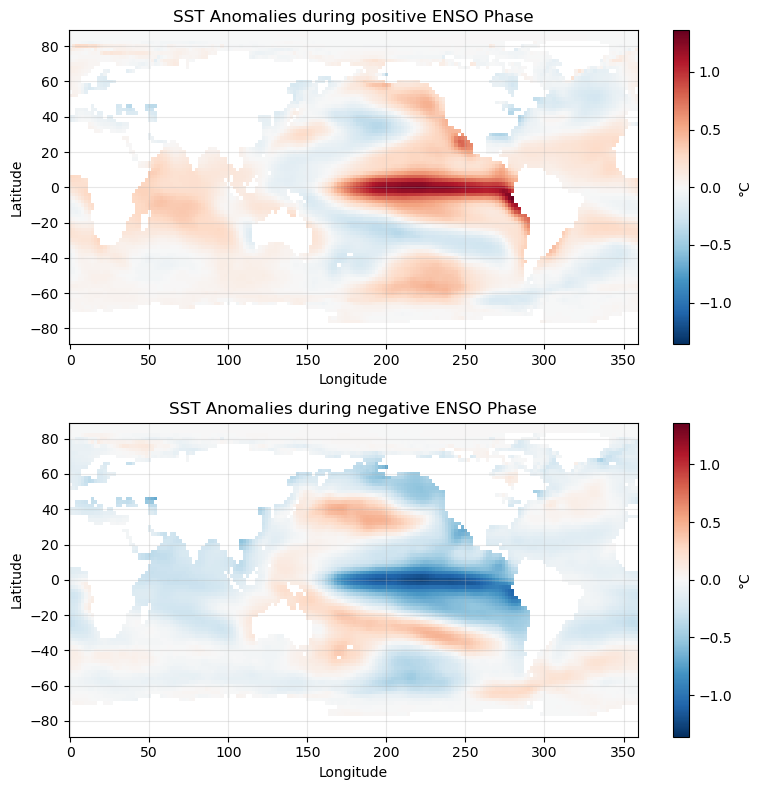

In [66]:
# Extract the SST data from 1950 onwards
sst = ds.sst.sel(time=slice('1950-01-01','2024-02-01'))

# Calculate mean sst across time
mean_sst = sst.mean(dim='time')

# Calculate anomalies
sst_anomalies = sst - mean_sst

# Apply masks
positive = sst_anomalies.where(elnino_mask)
negative = sst_anomalies.where(lanina_mask)

# Calculate mean anomalies across time
positive_anomalies = positive.mean(dim='time')
negative_anomalies = negative.mean(dim='time')

# Plot
fig, ax = plt.subplots(figsize=(8, 8), nrows=2)

plot_positive_anomalies = ax[0].pcolormesh(positive_anomalies.lon, positive_anomalies.lat, positive_anomalies, vmin=-1.36, vmax=1.36, cmap='RdBu_r')
plt.colorbar(plot_positive_anomalies, ax=ax[0], label='°C')
ax[0].set_title('SST Anomalies during positive ENSO Phase')
ax[0].set_xlabel('Longitude')  
ax[0].set_ylabel('Latitude')
ax[0].grid(True, alpha=0.3)

plot_negative_anomalies = ax[1].pcolormesh(negative_anomalies.lon, negative_anomalies.lat, negative_anomalies, vmin=-1.36, vmax=1.36, cmap='RdBu_r')
plt.colorbar(plot_positive_anomalies, ax=ax[1], label='°C')
ax[1].set_title('SST Anomalies during negative ENSO Phase')
ax[1].set_xlabel('Longitude')  
ax[1].set_ylabel('Latitude')
ax[1].grid(True, alpha=0.3)

plt.tight_layout()

## 4. Calculate the composite of preciptiation for positive and negative ENSO phases.
First load the precip dataset. Code to fix the broken time coordinate is included.
Now plot the difference between the time-mean of prcp during positive and negative ENSO phases.

In [7]:
import pandas as pd
import xarray as xr
url = 'http://iridl.ldeo.columbia.edu/SOURCES/.NASA/.GPCP/.V2p1/.multi-satellite/.prcp/dods'
dsp = xr.open_dataset(url, decode_times=False)
true_time = (pd.date_range(start='1960-01-01', periods=len(dsp['T']), freq='MS'))
dsp['T'] = true_time
dsp = dsp.rename({'T': 'time'})
dsp.load()

<xarray.Dataset>
Dimensions:  (X: 144, time: 356, Y: 72)
Coordinates:
  * X        (X) float32 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 1989-08-01
  * Y        (Y) float32 88.75 86.25 83.75 81.25 ... -81.25 -83.75 -86.25 -88.75
Data variables:
    prcp     (time, Y, X) float32 nan nan nan nan ... 0.6489 0.6437 0.636 0.6303
Attributes:
    Conventions:  IRIDL

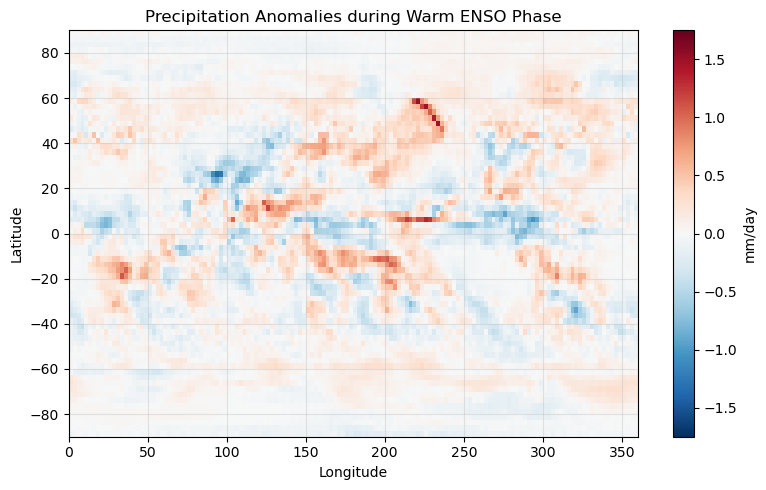

In [100]:
# Filter precipitation data for warm and cold phases using boolean masks
prcp_warm = dsp.prcp.where(elnino_mask)
prcp_cold = dsp.prcp.where(lanina_mask)

# Take the time average of precipitation for warm and cold phases
prcp_warm_mean = prcp_warm.mean(dim='time')
prcp_cold_mean = prcp_cold.mean(dim='time')

# Difference between warm and cold phase
difference = prcp_warm_mean - prcp_cold_mean

# Plot
plt.subplots(figsize=(8, 5))

plot_difference = plt.pcolormesh(difference.X, difference.Y, difference, vmin=-1.75, vmax=1.75, cmap='RdBu_r')
plt.colorbar(plot_difference, label='mm/day')
plt.title('Precipitation Anomalies during Warm ENSO Phase')
plt.xlabel('Longitude')  
plt.ylabel('Latitude')
plt.grid(True, alpha=0.3)

#plot_cold_difference = ax[1].pcolormesh(cold_difference.X, cold_difference.Y, cold_difference, vmin=-1.7, vmax=1.7, cmap='RdBu')
#plt.colorbar(plot_cold_difference, ax=ax[1], label ='mm/day')
#ax[1].set_title('Precipitation Anomalies during Cold ENSO Phase')
#ax[1].set_xlabel('Longitude')  
#ax[1].set_ylabel('Latitude')
#ax[1].grid(True, alpha=0.3)


plt.tight_layout()

## Notes (not actual answers!)

## Another way to plot data for Q3.

In [9]:
# Extract the SST data for the Niño 3.4 region from 1950 onwards
#nino34_sst = ds.sst.sel(lat=slice(5, -5), lon=slice(190, 240), time=slice('1950-01-01','2024-02-01'))

# Define a function to calculate monthly anomalies
#def anomaly(x):
    #return (x - x.mean())

# Calculate anomalies for each month
#nino34_sst_anomalies = nino34_sst.groupby('time.month').apply(anomaly)
#nino34_sst_anomalies

# Calculate the 3-month running mean of anomalies
#running_nino34_sst_anomalies = nino34_sst_anomalies.rolling(time=3, center=True).mean()

# Plot the 3-month running mean curve
#plt.plot(running_nino34_sst_anomalies.time, running_nino34_sst_anomalies.mean(dim=('lat', 'lon')), color='black', label='3-month running mean');
#plt.fill_between(running_nino34_sst_anomalies.time, 0, 
                 #running_nino34_sst_anomalies.mean(dim=('lat', 'lon')), 
                 #where=running_nino34_sst_anomalies.mean(dim=('lat', 'lon')) > 0, color='orange', interpolate=True);
#plt.fill_between(running_nino34_sst_anomalies.time, 0, 
                 #running_nino34_sst_anomalies.mean(dim=('lat', 'lon')), 
                 #where=running_nino34_sst_anomalies.mean(dim=('lat', 'lon')) < 0, color ='cyan', interpolate=True);

#plt.axhline(y=0, color='black', linestyle='-');

#plt.xlim(running_nino34_sst_anomalies.time.min(), running_nino34_sst_anomalies.time.max());
#plt.title('SST Anomaly in Niño 3.4 Region (5N–5S, 120–170W)');
#plt.xlabel('Year');
#plt.ylabel('Anomaly in (°C)');
#plt.legend();


In [ ]:
# What the elnino and lanina masks do:

# Create boolean masks for warm and cold phases
#elnino_mask = ((ONI > 0.5).rolling(time=5, center=True).sum()==5).rolling(time=5, center=True, min_periods=1).max()
#lanina_mask = ((ONI < -0.5).rolling(time=5, center=True).sum()==5).rolling(time=5, center=True, min_periods=1).max()

# ONI > 0.5: This condition checks whether the Oceanic Niño Index (ONI) values are greater than 0.5. 

#.rolling(time=5, center=True).sum(): Apply rolling window operation along the time dimension with a window size of 5, centered around each time point. 
#This effectively counts how many consecutive time points within the window have ONI values greater than 0.5.

# == 5: After applying the rolling sum, this condition checks if the sum within the window is equal to 5. 
# This means that for a given time point, the previous and next 2 time points on each side (totaling 5 time points) all have ONI values greater than 0.5.

# .rolling(time=5, center=True, min_periods=1): 
# This part applies another rolling window operation with the same window size and centering, but with a minimum number of periods set to 1. 
# This ensures that the rolling operation is performed even if there are fewer than 5 valid time points in the window.

# .max(): This effectively identifies the longest consecutive sequence of time points where the ONI values are consistently greater than 0.5.

# 